# Note: python version used = 3.11.9

In [32]:
!pip install faker numpy pandas


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\UnselfishMedium5\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Part 1: Creation of data

## Import the Libraries 

In [33]:
import numpy as np
import pandas as pd
import faker # main
import random

In [34]:
fake = faker.Faker()
N_rows = 1000
output_file = "sinthetic_bodyfat_data.csv"
data =[]

## Functions

In [35]:
def calculate_bmi (weight,height_cm):
    height_m = height_cm/100
    return weight/(height_m ** 2)

def generate_bodyfat_data (gender, bmi, waist, neck_cm):
    if gender == 1: # Male
        bf = (
            0.25 * bmi + 
            0.40 * waist_cm - 
            0.20 * neck_cm - 
            5.0 + # Constant to align with biological norms
            np.random.normal(0, 1.2)
        )
        return np.clip(bf,3,40)
    else : # Female
        bf = (
            0.30 * bmi + 
            0.45 * waist_cm - 
            0.15 * neck_cm - 
            2.0 + 
            np.random.normal(0, 1.5)
        )
        return np.clip(bf, 12, 50)

In [36]:
def generate_linear_friendly_data(n_samples=1000):
    np.random.seed(42) # For consistent results
    
    # 1. Generate independent features
    gender = np.random.randint(0, 2, n_samples) # 0 for Female, 1 for Male
    weight = np.random.uniform(50, 110, n_samples)
    height_cm = np.random.uniform(150, 190, n_samples)
    waist_cm = np.random.uniform(70, 110, n_samples)
    neck_cm = np.random.uniform(30, 45, n_samples)

    # 2. Calculate a simplified BMI (Linearized for the model)
    # We use (weight/height) instead of (weight/height^2) to help Linear Regression
    bmi_linear = weight / (height_cm / 100) 

    # 3. Generate Body Fat using a purely Linear Equation
    # No complex clipping, just a clean linear combination
    bf = (
        (gender * -5.0) +          # Males typically have lower BF for same BMI
        (bmi_linear * 0.6) + 
        (waist_cm * 0.2) - 
        (neck_cm * 0.1) + 
        np.random.normal(0, 0.8)   # Reduced noise to keep R2 high
    )

    # Clean up the ranges slightly without hard-clipping at 35/45
    bf = np.maximum(bf, 5) 

    return pd.DataFrame({
        'Gender': gender,
        'Weight': weight,
        'Height': height_cm,
        'Waist': waist_cm,
        'Neck': neck_cm,
        'BodyFat': bf
    })

# Generate the data
df = generate_linear_friendly_data()

## Data Generation

In [37]:
for i in range(N_rows):
    age = random.randint(18, 40)
    gender = random.choice([0, 1]) # 0 = Female, 1 = Male
    if gender == 1:
        height_cm = random.randint(160, 185)
        neck_cm = random.uniform(34, 42)
    else:
        height_cm = random.randint(150, 175)
        neck_cm = random.uniform(30, 38)
    bmi = random.uniform(18, 32)
    weight_kg = bmi * (height_cm / 100) ** 2
    weight_kg += random.uniform(-2, 2)
    waist_cm = random.uniform(0.45, 0.60) * height_cm
    waist_cm += random.uniform(-2, 2)
    body_fat = generate_bodyfat_data(
        gender,
        calculate_bmi(weight_kg, height_cm),
        waist_cm,
        neck_cm
        )
    data.append([
        age,
        gender,
        round(height_cm, 1),
        round(weight_kg, 1),
        round(waist_cm, 1),
        round(neck_cm, 1),
        round(body_fat, 1)
        ])

## Create DataFrame & Export

In [38]:
columns = [
"age",
"gender",
"height_cm",
"weight_kg",
"waist_cm",
"neck_cm",
"body_fat_percent"
]


df = pd.DataFrame(data, columns=columns)
df.to_csv(output_file, index=False)


print(f" Synthetic dataset generated: {output_file}")
print(df.head())


 Synthetic dataset generated: sinthetic_bodyfat_data.csv
   age  gender  height_cm  weight_kg  waist_cm  neck_cm  body_fat_percent
0   22       1        165       76.6      79.0     37.7              29.1
1   22       1        182       98.2      88.9     36.8              28.4
2   30       0        152       48.6      92.0     35.5              40.3
3   34       0        154       57.0      83.5     31.6              39.0
4   18       1        160       72.5      77.8     40.9              25.1


In [39]:
print(df.tail())

     age  gender  height_cm  weight_kg  waist_cm  neck_cm  body_fat_percent
995   23       0        159       51.6      82.1     36.1              36.2
996   31       0        150       57.9      70.7     30.6              32.6
997   27       0        170       86.9      77.9     37.1              38.6
998   23       1        179       60.1      86.6     40.9              27.2
999   27       1        182       98.7      85.3     36.2              30.4


# Part 2: EDA

In [40]:
import pandas as pd
df = pd.read_csv("sinthetic_bodyfat_data.csv")
df.head()
df.shape
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1000 non-null   int64  
 1   gender            1000 non-null   int64  
 2   height_cm         1000 non-null   int64  
 3   weight_kg         1000 non-null   float64
 4   waist_cm          1000 non-null   float64
 5   neck_cm           1000 non-null   float64
 6   body_fat_percent  1000 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 54.8 KB


,age,gender,height_cm,weight_kg,waist_cm,neck_cm,body_fat_percent
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,28.828000,0.470000,166.934000,70.162200,87.566400,35.928400,34.441500
std,6.756335,0.499349,8.919597,13.675025,8.833604,3.141946,6.052611
min,18.000000,0.000000,150.000000,42.100000,67.600000,30.000000,18.900000
25%,23.000000,0.000000,160.000000,59.400000,80.500000,33.500000,30.075000
50%,29.000000,0.000000,167.000000,69.300000,87.600000,35.900000,34.200000
75%,35.000000,1.000000,173.000000,80.225000,94.125000,38.000000,38.700000
max,40.000000,1.000000,185.000000,108.100000,111.100000,42.000000,50.000000


## Graph plotting

In [41]:
!pip install matplotlib


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\UnselfishMedium5\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


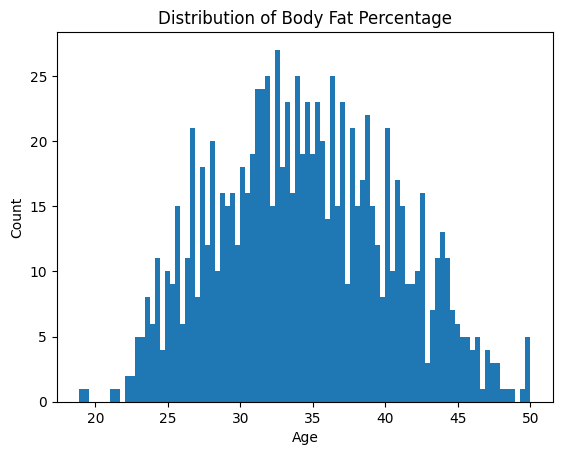

In [42]:
import matplotlib.pyplot as plt

plt.hist(df["body_fat_percent"],bins=90)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Body Fat Percentage")
plt.show()

## Gender wise body fat comparision

In [43]:
df.groupby('gender')["body_fat_percent"].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
0,530.0,38.635472,4.390046,28.5,35.4,38.5,41.7,50.0
1,470.0,29.712128,3.742074,18.9,26.8,29.9,32.4,38.5


In [44]:
corr = df.corr(numeric_only=True)
corr["body_fat_percent"].sort_values()

gender             -0.736188
neck_cm            -0.536697
height_cm          -0.157655
age                 0.016602
weight_kg           0.051141
waist_cm            0.359321
body_fat_percent    1.000000
Name: body_fat_percent, dtype: float64

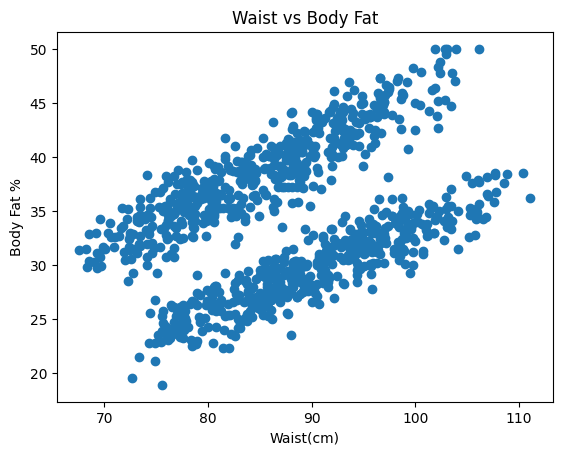

In [45]:
plt.scatter(df["waist_cm"],df["body_fat_percent"])
plt.xlabel('Waist(cm)')
plt.ylabel('Body Fat %')
plt.title("Waist vs Body Fat")
plt.show()

## outlier

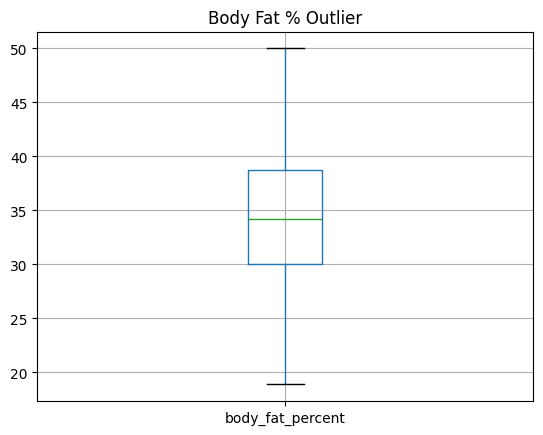

In [46]:
df.boxplot(column="body_fat_percent")
plt.title("Body Fat % Outlier")
plt.show()

In [47]:
assert (df["waist_cm"] < df["height_cm"]).all()
assert (df["neck_cm"] < df["waist_cm"]).all()
assert (df["body_fat_percent"] > 0).all()

# Modelling

In [48]:
import pandas as pd

df=pd.read_csv("sinthetic_bodyfat_data.csv")

In [49]:
x = df[["age","gender","height_cm","weight_kg","waist_cm","neck_cm"]]
y = df["body_fat_percent"]

In [50]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [52]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train_scaled,y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


### make prediction

In [53]:
y_pred = model.predict(x_test_scaled)

In [54]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)

print("MAE:", round(mae, 2))
print("RMSE:",round(rmse, 2))
print("R2:", round(r2, 3))

MAE: 1.17
RMSE: 1.43
R2: 0.947


### Inspect Feature Importance

In [55]:
coefficients =pd.DataFrame({"Feature":x.columns,
                            "Coefficient": model.coef_})

print(coefficients.sort_values(by="Coefficient",ascending=False))

     Feature  Coefficient
4   waist_cm     3.765349
3  weight_kg     1.355527
0        age     0.049286
5    neck_cm    -0.465581
2  height_cm    -0.615376
1     gender    -5.340594


##### train vs test rating

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(x_train, y_train)

train_preds = model.predict(x_train)
test_preds = model.predict(x_test)

print(f"Shapes: {y_train.shape}, {train_preds.shape}")

print(f"New Train R2: {r2_score(y_train, train_preds)}")
print(f"New Test R2: {r2_score(y_test, test_preds)}")

Shapes: (800,), (800,)
New Train R2: 0.9487343817427017
New Test R2: 0.9468455405061762


#### Quick Visuallise

In [57]:
import matplotlib.pyplot as plt

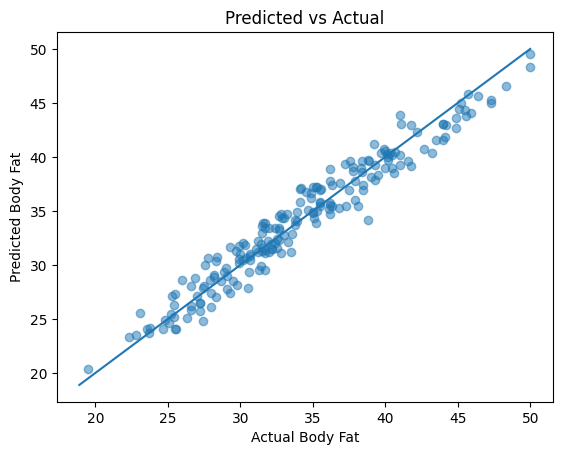

In [58]:
plt.scatter(y_test,y_pred,alpha=0.5)
plt.xlabel("Actual Body Fat")
plt.ylabel("Predicted Body Fat")
plt.title("Predicted vs Actual")
plt.plot([y.min(),y.max()],[y.min(),y.max()])

# Body fat category function

## creating health zone

In [59]:
def classify_body_fat(bf, gender):

    if gender == 1:  # Male
        if bf < 14:
            return "Lean"
        elif bf < 20:
            return "Healthy"
        elif bf < 25:
            return "Average"
        elif bf < 30:
            return "Overfat"
        else:
            return "Obese"
    else:  # Female
        if bf < 20:
            return "Lean"
        elif bf < 28:
            return "Healthy"
        elif bf < 34:
            return "Average"
        elif bf < 40:
            return "Overfat"
        else:
            return "Obese"

### safe fat loss limits

In [60]:
MAX_WEEKLY_WEIGHT_LOSS = 0.01 #1%
MAX_DAILY_DEFICIT = 500  #kcal

MIN_BF_MALE = 12
MIN_BF_FEMALE = 20

### Recommendation generator (core logic)

In [61]:
def generate_recommendation(pred_bf, weight, gender):
    category = classify_body_fat(pred_bf, gender)

    # Safe minimum body fat
    min_bf = MIN_BF_MALE if gender == 1 else MIN_BF_FEMALE

    # Target body fat (reduce by ~3–4% but not below safe limit)
    target_bf = max(pred_bf - 4, min_bf)

    # Timeline estimate (0.7% BF per month)
    bf_to_lose = pred_bf - target_bf
    months = bf_to_lose / 0.7 if bf_to_lose > 0 else 0

    # Calorie deficit (conservative)
    daily_deficit = min(400, MAX_DAILY_DEFICIT)

    # Priorities based on category
    if category in ["Overfat", "Obese"]:
        focus = [
            "Increase daily steps (8k–10k)",
            "Strength training 3x/week",
            "High protein intake (≈1.6 g/kg)",
            "Reduce sugary & liquid calories"
        ]
    else:
        focus = [
            "Strength training 3–4x/week",
            "Maintain protein intake",
            "Light cardio or walking",
            "Consistent sleep"
        ]

    return {
        "category": category,
        "current_bf": round(pred_bf, 1),
        "target_bf": round(target_bf, 1),
        "estimated_months": round(months, 1),
        "daily_calorie_deficit": daily_deficit,
        "focus_areas": focus,
        "safety_note": "Avoid aggressive dieting. Do not drop below safe body fat limits without medical supervision."
    }

### Connection of recommendation engine

In [62]:
sample_pred = y_pred[0]
sample_weight = x_test.iloc[0]["weight_kg"]
sample_gender = x_test.iloc[0]["gender"]

recommendation = generate_recommendation( # rule based expert system
    sample_pred,
    sample_weight,
    sample_gender
)

print(recommendation)

{'category': 'Obese', 'current_bf': np.float64(39.6), 'target_bf': np.float64(35.6), 'estimated_months': np.float64(5.7), 'daily_calorie_deficit': 400, 'focus_areas': ['Increase daily steps (8k–10k)', 'Strength training 3x/week', 'High protein intake (≈1.6 g/kg)', 'Reduce sugary & liquid calories'], 'safety_note': 'Avoid aggressive dieting. Do not drop below safe body fat limits without medical supervision.'}


## Model saving

In [ ]:
import joblib

joblib.dump(model,"bodyfat_linear_model.pkl")
joblib.dump(scaler,"scaler.pkl")

print("Model saved successfully")

Model saved successfully


## Creating a clean prediction function

#### making the ML callable

In [ ]:
def predict_body_fat(age, gender, height, weight, waist, neck):
    import numpy as np
    import joblib

    model = joblib.load("bodyfat_linear_model.pkl")
    scaler = joblib.load("scaler.pkl")

    x = np.array([[age, gender, height, weight, waist, neck]])
    x_scaled = scaler.transform(x)

    bf = model.predict(x_scaled)[0]
    return round(float(bf), 1)

In [69]:
bf = predict_body_fat(22, 1, 175, 72, 82, 38)

rec = generate_recommendation(bf, 72, 1)

print("Predicted Body Fat:", bf)
print(rec)

Predicted Body Fat: -0.2
{'category': 'Lean', 'current_bf': -0.2, 'target_bf': 12, 'estimated_months': 0, 'daily_calorie_deficit': 400, 'focus_areas': ['Strength training 3–4x/week', 'Maintain protein intake', 'Light cardio or walking', 'Consistent sleep'], 'safety_note': 'Avoid aggressive dieting. Do not drop below safe body fat limits without medical supervision.'}


C:\Users\UnselfishMedium5\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\UnselfishMedium5\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
